In [1]:
import pandas as pd
import yfinance as yf

# 下载 AAPL（苹果公司）历史数据
stock = yf.download("AAPL", start="2023-01-01", end="2024-01-01")

# 查看数据
print(stock.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2023-01-03  123.632530  129.395518  122.742873  128.782649  112117500
2023-01-04  124.907707  127.181276  123.642420  125.431615   89113600
2023-01-05  123.583092  126.301485  123.326085  125.668841   80962700
2023-01-06  128.130234  128.792531  123.454601  124.561732   87754700
2023-01-09  128.654144  131.876686  128.397138  128.970474   70790800


In [9]:
import talib
stock = stock.reset_index()  # 这样 'Date' 会变成普通列
stock.columns = stock.columns.droplevel(1)  # 删除第 1 层索引
# 计算 RSI（14 天）
stock["RSI"] = talib.RSI(stock["Close"], timeperiod=14)

# 计算 50 天 & 200 天均线
stock["Short_MA"] = stock["Close"].rolling(window=50).mean()
stock["Long_MA"] = stock["Close"].rolling(window=200).mean()


In [10]:
# 交易信号
stock["Buy_Signal"] = (stock["RSI"] < 30) | (stock["Short_MA"] > stock["Long_MA"])
stock["Sell_Signal"] = (stock["RSI"] > 70) | (stock["Short_MA"] < stock["Long_MA"])


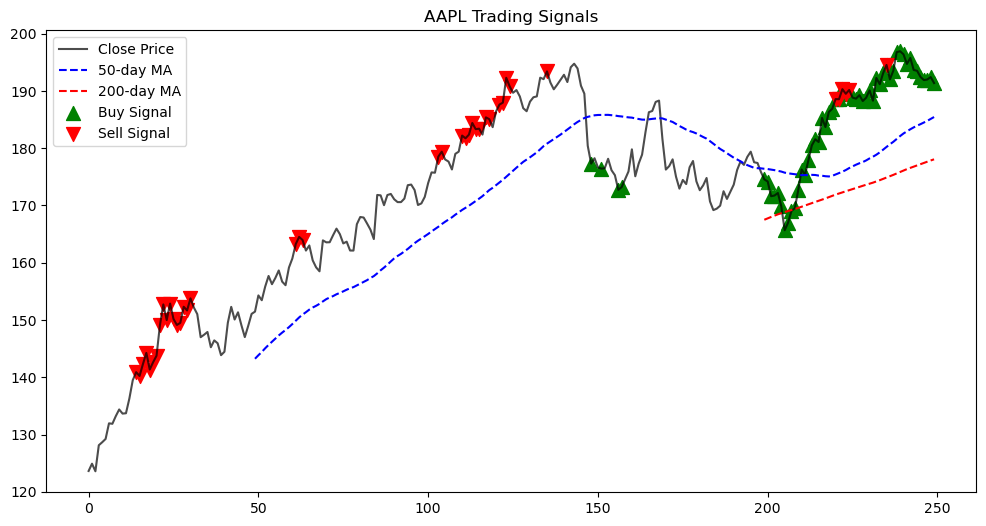

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# 画出收盘价
plt.plot(stock["Close"], label="Close Price", color="black", alpha=0.7)

# 画出均线
plt.plot(stock["Short_MA"], label="50-day MA", color="blue", linestyle="--")
plt.plot(stock["Long_MA"], label="200-day MA", color="red", linestyle="--")

# 标记买入点
plt.scatter(stock.index[stock["Buy_Signal"]], stock["Close"][stock["Buy_Signal"]], 
            label="Buy Signal", marker="^", color="green", alpha=1, s=100)

# 标记卖出点
plt.scatter(stock.index[stock["Sell_Signal"]], stock["Close"][stock["Sell_Signal"]], 
            label="Sell Signal", marker="v", color="red", alpha=1, s=100)

plt.title("AAPL Trading Signals")
plt.legend()
plt.show()


In [12]:
import numpy as np

# 计算每日收益
stock["Daily_Return"] = stock["Close"].pct_change()

# 计算策略收益（假设只在买入信号买入）
stock["Strategy_Return"] = stock["Daily_Return"] * stock["Buy_Signal"].shift(1)

# 计算累计收益
stock["Cumulative_Return"] = (1 + stock["Strategy_Return"]).cumprod()

# 计算最大回撤
cumulative_max = stock["Cumulative_Return"].cummax()
stock["Drawdown"] = (stock["Cumulative_Return"] - cumulative_max) / cumulative_max

# 计算夏普比率
sharpe_ratio = stock["Strategy_Return"].mean() / stock["Strategy_Return"].std() * np.sqrt(252)

print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"最大回撤: {stock['Drawdown'].min():.2%}")


夏普比率: 1.53
最大回撤: -5.09%
